# Urban Heat Island (UHI) Benchmark Notebook 

## Model Objective:

The objective of this notebook is to build a machine learning model to predict <b>Urban Heat Island (UHI) intensity levels</b> across urban environments. The goal is to develop a classification model that can categorize UHI intensity into three discrete classes: <b>Low</b>, <b>Moderate</b>, and <b>High</b>, based on spatial and contextual geospatial data.

<b>About Notebook: </b><p align="justify"> <p>

<p align="justify">This reference notebook is designed as a practical learning resource for students to explore how machine learning techniques can be applied to geospatial and satellite data for classifying Urban Heat Island (UHI) intensity into three categories: <b>Low</b>, <b>Medium</b>, and <b>High</b>. It guides students through the complete modeling workflow—from data preparation to prediction—using real-world datasets.</p> 

<p align="justify">To familiarize students with remote sensing data, the notebook uses spectral indices derived from 
<a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 Level-2A</a>
satellite imagery: NDVI (Normalized Difference Vegetation Index), NDBI (Normalized Difference Built-up Index), and NDWI (Normalized Difference Water Index). These indices capture key environmental features such as vegetation health, built-up areas, and water presence. In addition, building density is incorporated as a spatial predictor, derived from the three-dimensional building footprints available in the <a href="https://zenodo.org/records/13694392">3D-GloBFP dataset</a>, the first global dataset providing 3D building information.</p> 

<p align="justify">The training dataset consists of ground-truth UHI class labels with geographic coordinates (latitude and longitude) collected from two urban regions—Santiago, Chile (on January 20, 2024), and Rio de Janeiro, Brazil (on January 27, 2023). Sentinel-2 images were downloaded using acquisition dates that are closest to the ground-based UHI data collection dates for each location, to best capture the relevant surface characteristics.</p> 

<p align="justify">The trained model is then tested on an unseen region, Freetown, Sierra Leone, where ground-based UHI labels were collected on January 24, 2023. This setup illustrates the ability of the model to generalize patterns learned from the training regions and apply them to new urban environments.</p> 

<p align="justify">The classification model used is a Random Forest trained on the combined features of NDVI, NDBI, NDWI, and building density. This demonstrates how satellite-derived spectral indices and structural urban features can be integrated into a machine learning workflow for environmental prediction tasks.</p> 

<p align="justify">This notebook walks students through the entire process, including integrating raster data (Sentinel-2 GeoTIFF imagery) with vector data (3D building footprint shapefiles), extracting relevant features, preparing the dataset for machine learning, training the Random Forest classifier, and evaluating its predictive performance. It serves as a foundational example, encouraging students to experiment further by incorporating additional variables, exploring temporal dynamics, tuning model parameters, or testing alternative algorithms.</p> 

<p align="justify">While the approach makes certain simplifying assumptions—such as using data from a single date per region and extracting spectral indices at specific points—this practical demonstration offers an accessible starting point for understanding UHI modeling. Students are invited to challenge these assumptions, expand the dataset, or refine methodologies to better capture the complexities of urban heat distribution.</p> 

<p align="justify">Many of the functions and methodologies presented in this notebook are adapted from publicly available resources, including the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 Level-2A example notebook</a> on the Planetary Computer portal and the <a href="https://zenodo.org/records/13694392">3D-GloBFP dataset</a> published in the Earth System Science Data (ESSD) journal.</p>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets (e.g., NetCDF, Zarr)
import xarray as xr

# Geospatial raster data handling with CRS support
import rioxarray as rxr

# Geospatial vector data handling (e.g., shapefiles, GeoJSON)
import geopandas as gpd
from shapely.geometry import box, Point

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Raster operations and spatial windowing
import rasterio
from rasterio.windows import from_bounds

# Feature preprocessing and data splitting
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Machine learning model and evaluation metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# Planetary Computer tools for STAC API access and authentication
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Progress bar for loops
from tqdm import tqdm

The ground-based temperature data has been put into 3 categories: Low, Medium and High. These categories represent the intensity of the urban heat island effect. For example, the LOW category represents temperatures that are more than 2% below the mean. The HIGH category represents temperatures that are more than 2% above the mean. The MEDIUM category represents temperatures within 2% of the mean. These 3 classes are used to simplify the modeling process while still identifying the regions of HIGH temperatures coincident with urban heat islands. 

## Response Variable

Before building the model, we first load the Urban Heat Island (UHI) Intensity classification training datasets curated for Santiago (Chile) and Rio de Janeiro (Brazil). This dataset includes geo-referenced points (latitude and longitude)and the UHI class, which categorizes the heat intensity at each location into Low, Medium, or High. This labeled dataset forms the basis for training our classification model, which will later be used to predict UHI intensity classes in Freetown, Sierra Leone.

In [2]:
chile_heat_df=pd.read_csv('../data/sample_chile_uhi_data.csv')
chile_heat_df.head()

,Longitude,Latitude,UHI_Class
0,-70.580508,-33.586980,Low
1,-70.579480,-33.592099,Low
2,-70.578366,-33.597419,Medium
3,-70.566661,-33.597109,Low
4,-70.566296,-33.597079,Medium


In [3]:
Brazil_heat_df=pd.read_csv('../data/sample_Brazil_uhi_data.csv')
Brazil_heat_df.head()

,Longitude,Latitude,UHI_Class
0,-43.278320,-22.901192,Medium
1,-43.278298,-22.901215,Medium
2,-43.278277,-22.901235,Medium
3,-43.278218,-22.901298,Medium
4,-43.278185,-22.901335,Medium


## Predictor Variables

<p align="justify">Now that we have the UHI data, the next step is to gather relevant predictor variables to train our model. The key predictors used in this notebook include spectral indices derived from the Sentinel-2 satellite dataset, and the building density feature obtained from the 3D-GloBFP dataset. Students are encouraged to review the provided Sentinel-2 sample notebook for guidance on querying and downloading Sentinel-2 imagery from the Microsoft Planetary Computer. For further reference, consult the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>.

</p> <p align="justify">Sentinel-2 provides high-resolution multispectral imagery that is instrumental in characterizing land surface conditions. In this notebook, we derive three widely used spectral indices—NDVI (Normalized Difference Vegetation Index), NDBI (Normalized Difference Built-up Index), and NDWI (Normalized Difference Water Index)—from various Sentinel-2 bands. These indices offer insight into vegetation health, impervious surface extent, and water presence, all of which are relevant to understanding urban heat patterns. Additionally, we use the building density feature sourced from the <a href="https://zenodo.org/records/13694392">3D-GloBFP: The First Global Three-Dimensional Building Footprint Dataset</a> to account for urban structure influence on UHI formation.

</p> <ul> <li><strong>NDVI</strong> – Derived from bands B08 (Near Infrared) and B04 (Red), this index indicates vegetation presence and health, which affects surface temperature and cooling.

</li> <li><strong>NDBI</strong> – Derived from bands B11 (Shortwave Infrared) and B08 (Near Infrared), this index highlights built-up areas that typically retain more heat.

</li> <li><strong>NDWI</strong> – Derived from bands B03 (Green) and B08 (Near Infrared), this index identifies surface water features, which can contribute to local cooling effects.

</li> <li><strong>Building_Density_100m</strong> – Computed from the 3D-GloBFP dataset, this feature captures the density of built-up structures within a 100-meter buffer around each point, offering a structural context to UHI intensity.</li> </ul>

<h4 style="color:rgb(255, 0, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Students should only use satellite data from the Sentinel-2 mission. We suggest using all of the Sentinel-2 spectral bands and other combinations of those bands in the form of spectral indices. These bands and indices can then be used as features in your model.

### Analyze the Sentinel-2 Data

<p align="justify">To gather the Sentinel-2 data, we generated GeoTIFF images for the following dates and regions — Santiago, Chile (18th January, 2024), Rio de Janeiro, Brazil (18th January, 2023), and Freetown, Sierra Leone (26th January, 2023). These dates were carefully selected to be as close as possible to the dates on which ground-based UHI data was collected in each respective region. For each region, Sentinel-2 bands — B02 (Blue), B03 (Green), B04 (Red), B08 (Near-Infrared), and B11 (SWIR) — were extracted. These bands were then used to compute important spectral indices such as NDVI (Normalized Difference Vegetation Index), NDBI (Normalized Difference Built-up Index), and NDWI (Normalized Difference Water Index), which serve as predictor variables in our UHI modeling. Students can refer to the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 sample notebook</a> for more insights on generating outputs like RGB and NDVI and for guidance on customizing the processing pipeline.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Students may choose any of these approaches based on their convenience. Given the large size of our dataset, using the API method can be time-consuming and computationally intensive. Therefore, in this sample notebook, we have opted for the second approach—working with pre-processed GeoTIFF images. Specifically, we extracted bands B02, B03, B04, B08, and B11 and derived key spectral indices such as NDVI, NDBI, and NDWI from these bands. 

<h4 style="color:rgb(255, 0, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, students might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series.

Students should review the Sentinel-2 supplementary notebook that demonstrates cloud filtering, masking and the creation of median mosaics.

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have locally downloaded three GeoTIFF files for the following dates and regions — Santiago, Chile (18th January, 2024), Rio de Janeiro, Brazil (18th January, 2023), and Sierra Leone (26th January, 2023): <b>sample_Santiago.tiff</b>, <b>sample_Rio.tiff</b>, and <b>sample_Sierra.tiff</b>. Each GeoTIFF contains three bands representing spectral indices: NDVI (Normalized Difference Vegetation Index), NDBI (Normalized Difference Built-up Index), and NDWI (Normalized Difference Water Index).

First, let’s visualize the bands of the downloaded GeoTIFF images.

In [4]:
# visualize the bands of the downloaded GeoTIFF images.
def plot_spectral_indices(tiff_path, location_name="Location"):
    """
    Reads and plots NDVI, NDBI, and NDWI bands from a GeoTIFF file.
    
    Parameters:
    - tiff_path (str): Path to the GeoTIFF file.
    - location_name (str): Name of the location to be shown in the plot title.
    """
    with rasterio.open(tiff_path) as src:
        NDVI = src.read(1)  # Band 1: NDVI
        NDBI = src.read(2)  # Band 2: NDBI
        NDWI = src.read(3)  # Band 3: NDWI

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    fig.suptitle(f"{location_name} - Spectral Indices", fontsize=16, color='darkblue', y=1.05)

    # NDVI plot
    im1 = axes[0].imshow(NDVI, cmap='viridis')
    axes[0].set_title('NDVI')
    fig.colorbar(im1, ax=axes[0])

    # NDBI plot
    im2 = axes[1].imshow(NDBI, cmap='viridis')
    axes[1].set_title('NDBI')
    fig.colorbar(im2, ax=axes[1])

    # NDWI plot
    im3 = axes[2].imshow(NDWI, cmap='viridis')
    axes[2].set_title('NDWI')
    fig.colorbar(im3, ax=axes[2])

    # Empty plot slot (optional)
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

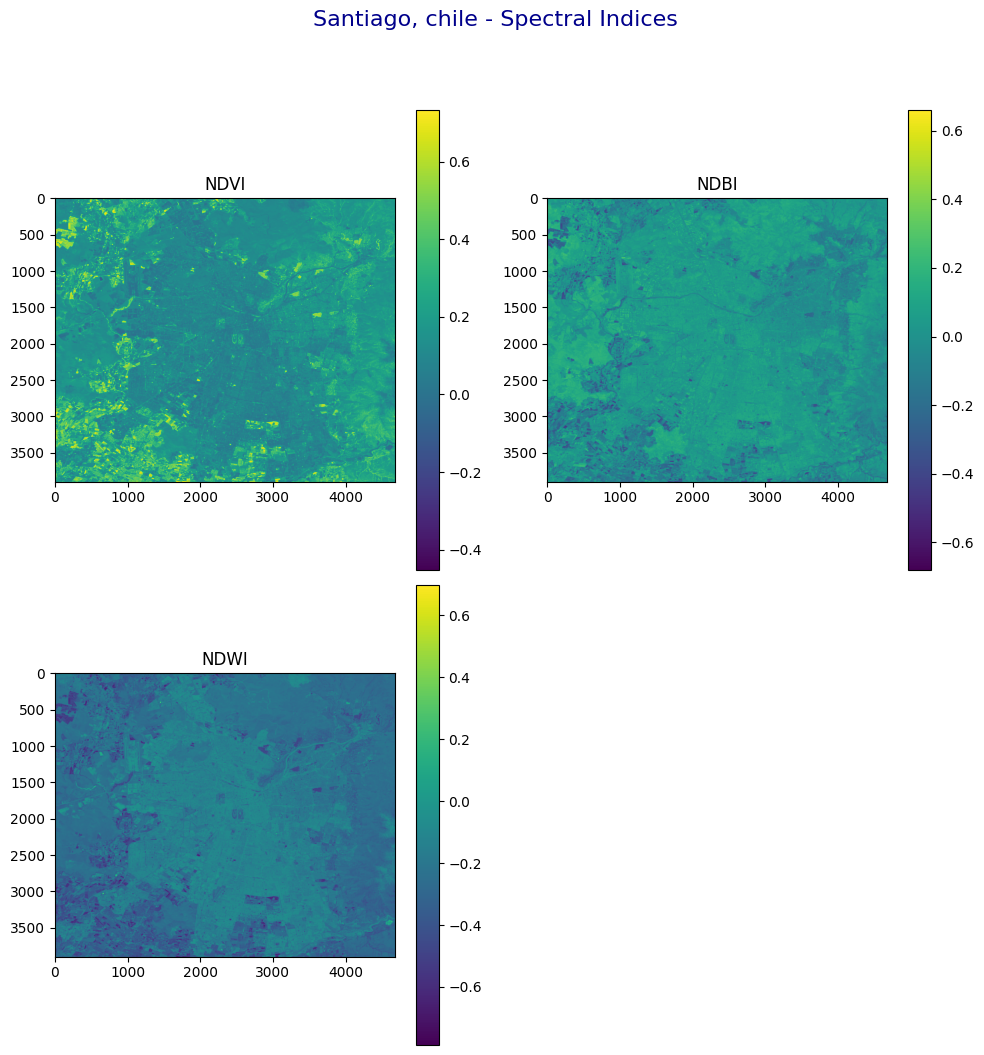

In [5]:
# For santiago location
plot_spectral_indices("../data/sample_chile.tiff", location_name="Santiago, chile")

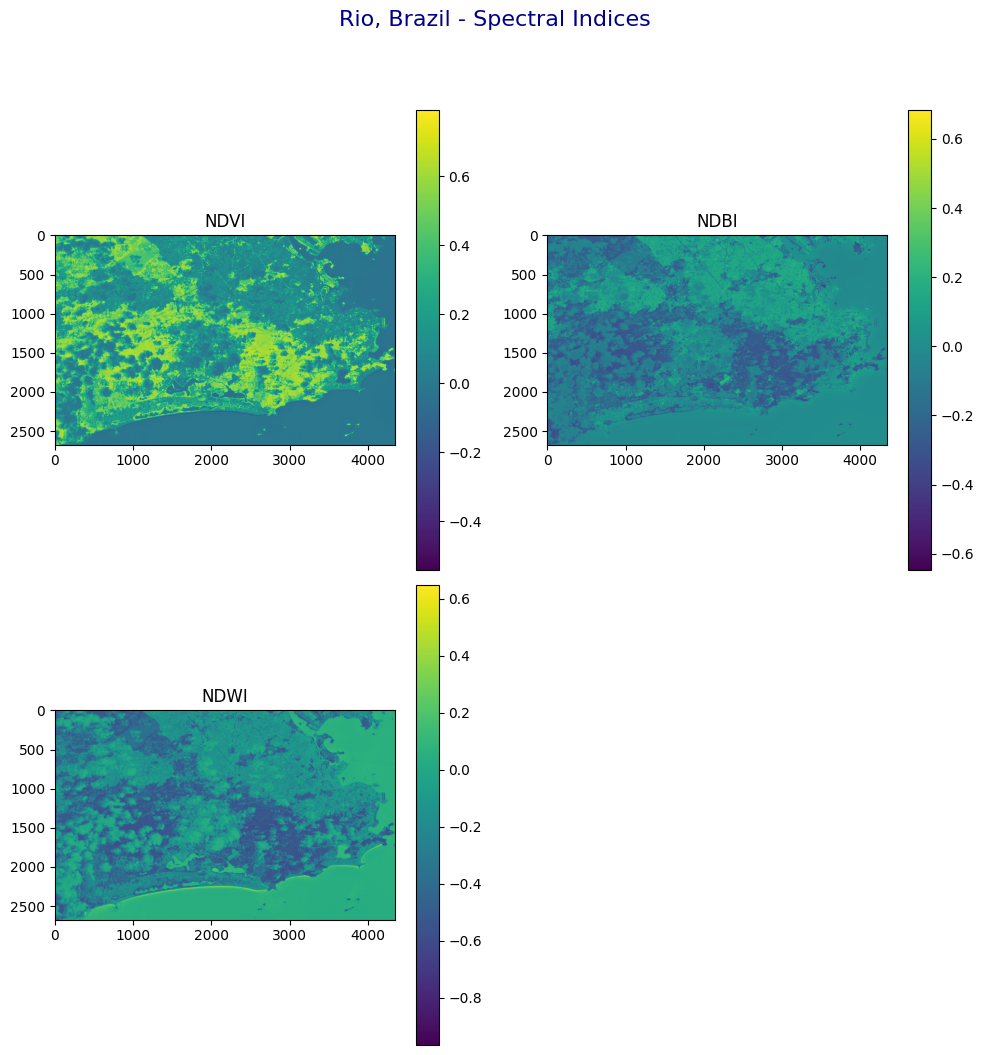

In [6]:
# For Rio location
plot_spectral_indices("../data/sample_Brazil.tiff", location_name="Rio, Brazil")

<h4 style="color:rgb(255, 0, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, students might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if a 50-meter buffer is applied to “NDBI” the extracted value would represent the average NDBI values within that radius. Exploring various buffer distances can help better capture spatial variability and reduce errors caused by spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.

The code below uses the “nearest” point method to identify satellite data values closest to the Lat-Lon positions of the UHI data. For the creation of a “buffer zone” around any given Lat-Lon location, students should review the Building Footprint section of this notebook as it samples data within a 100-meter buffer zone. 

In [10]:
# Extract spectral indices for each location
def extract_band_vales(
    geotiff_path,
    csv_input_path
):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(geotiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_input_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    median_NDVI = []
    median_NDBI = []
    median_NDWI = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        NDVI = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        median_NDVI.append(NDVI)
    
        NDBI = data.sel(x=lon, y=lat, band=2, method="nearest").values
        median_NDBI.append(NDBI)
        
        NDWI = data.sel(x=lon, y=lat, band=3, method="nearest").values
        median_NDWI.append(NDWI)


    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df["median_NDVI"] = median_NDVI
    df["median_NDBI"] = median_NDBI
    df["median_NDWI"] = median_NDWI

    return df

In [11]:
# Mapping satellite data with training data for the chile location.
chile_heat_data = extract_band_vales(geotiff_path="../data/sample_chile.tiff", csv_input_path="../data/sample_chile_uhi_data.csv")
chile_heat_data.head()



Mapping values: 100%|██████████| 21662/21662 [06:16<00:00, 57.52it/s] 


,Longitude,Latitude,UHI_Class,median_NDVI,median_NDBI,median_NDWI
0,-70.580508,-33.586980,Low,0.1583836507199257,0.05261158594491928,-0.17752596789423986
1,-70.579480,-33.592099,Low,0.19064493267186391,0.008264462809917356,-0.1988582302568982
2,-70.578366,-33.597419,Medium,0.039317858834675506,0.05512489233419466,-0.06349975763451285
3,-70.566661,-33.597109,Low,0.1606896551724138,0.025900737953986397,-0.1927710843373494
4,-70.566296,-33.597079,Medium,0.022598870056497175,0.003715425897894592,-0.07227488151658767


In [13]:
# Mapping satellite data with training data for the Brazil location.
Brazil_heat_data = extract_band_vales(geotiff_path="../data/sample_Brazil.tiff", csv_input_path="../data/sample_Brazil_uhi_data.csv")
Brazil_heat_data.head()

Mapping values: 100%|██████████| 28488/28488 [03:51<00:00, 123.13it/s]


,Longitude,Latitude,UHI_Class,median_NDVI,median_NDBI,median_NDWI
0,-43.278320,-22.901192,Medium,0.0327132777421424,-0.01689562608558345,-0.06870229007633588
1,-43.278298,-22.901215,Medium,0.0327132777421424,-0.01689562608558345,-0.06870229007633588
2,-43.278277,-22.901235,Medium,0.005279831045406547,0.04305578823923605,-0.028077753779697623
3,-43.278218,-22.901298,Medium,0.01802838511699271,0.15383389128008926,-0.0645808263136783
4,-43.278185,-22.901335,Medium,0.002041649652919559,0.11790079079798706,-0.045590115040477205


### Analyze the Building Footprint data

<p align="justify">
The building footprint data, including height information, was directly obtained from the <a href="https://zenodo.org/records/13694392">3D-GloBFP: The First Global Three-Dimensional Building Footprint Dataset</a> in Shapefile (.shp) format. 
Each entry contains the geometry of the building along with its corresponding height attribute. These shapefiles were spatially joined with the UHI dataset to derive relevant building-related features. Specifically, we computed the <em>building_density_100m</em> feature by calculating the density of buildings within a 100-meter buffer around each location in the UHI data.
</p>


### Downloading .shp files

<p align="justify">
We downloaded three Shapefiles — <em>Chile.shp</em>, <em>Brazil.shp</em>, and <em>Sierra Leone.shp</em> — corresponding to the regions of Santiago, Rio de Janeiro, and Sierra Leone, respectively, from the <a href="https://essd.copernicus.org/articles/16/5357/2024/essd-16-5357-2024-discussion.html">3D-GloBFP: The First Global Three-Dimensional Building Footprint Dataset</a>. These files were then used to spatially map building footprints and extract structural features relevant to each UHI region.
</p>


In [14]:
# Computes building density (buildings per square meter) within a square buffer (default: 100 meters)
# around each point defined in a CSV file. Input building footprints are read from a shapefile (.shp).
def compute_building_density(
    csv_path,
    buildings_shp_path,
    lat_col="Latitude",
    lon_col="Longitude",
    buffer_m=100
):
    """
    Computes building density (buildings per m²) within a square buffer around each point.

    Parameters:
    - csv_path: str, path to input CSV with latitude and longitude
    - buildings_kml_path: str, path to KML with building footprints
    - lat_col: str, column name for latitude
    - lon_col: str, column name for longitude
    - buffer_m: float, buffer size in meters (square)

    Returns:
    - GeoDataFrame with new column: 'building_density_100m'
    """

    # Load CSV and convert to GeoDataFrame
    df = pd.read_csv(csv_path)
    df['geometry'] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
    
    # Convert the DataFrame to a GeoDataFrame in WGS84 (EPSG:4326)
    gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")
    
    # Load the building footprints from the shapefile
    gdf_buildings = gpd.read_file(buildings_shp_path)
    
    # Reproject buildings GeoDataFrame to EPSG:3857 (Web Mercator) if not already in that CRS
    # This projection uses meters, which is essential for accurate area and distance calculations
    if gdf_buildings.crs != "EPSG:3857":
        gdf_buildings = gdf_buildings.to_crs(epsg=3857)

    # Reproject point geometries to EPSG:3857 for consistent metric-based buffering
    gdf_points = gdf_points.to_crs(epsg=3857)

    # Initialize a list to store computed building densities
    building_densities = []

    # Loop through each point to compute the number of buildings within the buffer
    for _, row in tqdm(gdf_points.iterrows(), total=len(gdf_points), desc="Calculating building density"):
        point_geom = row.geometry
        
        # Create a square buffer (bounding box) of side `buffer_m` centered on the point
        buffer_geom = box(
            point_geom.x - buffer_m / 2, point_geom.y - buffer_m / 2,
            point_geom.x + buffer_m / 2, point_geom.y + buffer_m / 2
        )

        # Select buildings that intersect with the buffer area
        buildings_in_buffer = gdf_buildings[gdf_buildings.geometry.intersects(buffer_geom)].copy()
        
        
        # Repair invalid geometries using a zero-width buffer (commonly used geometry fix)
        buildings_in_buffer["geometry"] = buildings_in_buffer.geometry.buffer(0)
        
        # Compute area of the square buffer in square meters
        area_m2 = buffer_geom.area
        
        # Count the number of buildings intersecting the buffer
        bldg_count = len(buildings_in_buffer)
        
        # Compute building density as count per square meter
        density = bldg_count / area_m2 if area_m2 > 0 else 0

        # Append the result to the list
        building_densities.append(density)
        
    # Add the computed densities as a new column in the points GeoDataFrame
    gdf_points["building_density_100m"] = building_densities
    return gdf_points


In [15]:
# Compute building density within 100-meter square buffers around each point 
# in the Santiago UHI dataset, using building footprints from 'Chile.shp'.
chile_buildings_data = compute_building_density(
    csv_path="../data/sample_chile_uhi_data.csv",
    buildings_shp_path="../data/Chile Building Footprints/Chile_clipped.shp")


# Preview the first few rows of the resulting GeoDataFrame, 
# which now includes a 'building_density_100m' column.
chile_buildings_data.head()


Calculating building density: 100%|██████████| 21662/21662 [52:12<00:00,  6.91it/s]  


,Longitude,Latitude,UHI_Class,geometry,building_density_100m
0,-70.580508,-33.586980,Low,POINT (-7856986.247 -3973477.416),0.0005
1,-70.579480,-33.592099,Low,POINT (-7856871.774 -3974161.536),0.0002
2,-70.578366,-33.597419,Medium,POINT (-7856747.761 -3974872.544),0.0001
3,-70.566661,-33.597109,Low,POINT (-7855444.813 -3974831.078),0.0012
4,-70.566296,-33.597079,Medium,POINT (-7855404.166 -3974827.012),0.0010


In [16]:
# Compute building density within 100-meter square buffers around each point 
# in the Rio UHI dataset, using building footprints from 'Brazil.shp'.
Brazil_buildings_data = compute_building_density(
    csv_path="../data/sample_Brazil_uhi_data.csv",
    buildings_shp_path="../data/Brazil Building Footprints/Brazil_clipped.shp")


# Preview the first few rows of the resulting GeoDataFrame, 
# which now includes a 'building_density_100m' column.
Brazil_buildings_data.head()


Calculating building density: 100%|██████████| 28488/28488 [56:33<00:00,  8.40it/s]  


,Longitude,Latitude,UHI_Class,geometry,building_density_100m
0,-43.278320,-22.901192,Medium,POINT (-4817720.545 -2620073.807),0.0002
1,-43.278298,-22.901215,Medium,POINT (-4817718.132 -2620076.626),0.0002
2,-43.278277,-22.901235,Medium,POINT (-4817715.721 -2620079.043),0.0002
3,-43.278218,-22.901298,Medium,POINT (-4817709.227 -2620086.696),0.0002
4,-43.278185,-22.901335,Medium,POINT (-4817705.517 -2620091.128),0.0002


In [17]:
# Combine UHI data with extracted building density feature for Santiago.
# Selected features include location (Longitude, Latitude), UHI classification,
# median vegetation, built-up, and water indices, along with building density.
chile_combined = pd.concat([chile_heat_data[['Longitude', 'Latitude', 'UHI_Class', 'median_NDVI', 'median_NDBI', 'median_NDWI']], 
                               chile_buildings_data[['building_density_100m']]], axis=1)

# Repeat the same combination for Rio de Janeiro.
Brazil_combined = pd.concat([Brazil_heat_data[['Longitude', 'Latitude', 'UHI_Class', 'median_NDVI', 'median_NDBI', 'median_NDWI']], 
                          Brazil_buildings_data[['building_density_100m']]], axis=1)


In [18]:
# Merge the combined data from Santiago and Rio into a single training DataFrame.
# This unified dataset includes UHI class, spectral indices, and building density features.
train_df= pd.concat([chile_combined,Brazil_combined], axis=0)

# Preview the first few rows of the training dataset.
train_df.head()

,Longitude,Latitude,UHI_Class,median_NDVI,median_NDBI,median_NDWI,building_density_100m
0,-70.580508,-33.586980,Low,0.1583836507199257,0.05261158594491928,-0.17752596789423986,0.0005
1,-70.579480,-33.592099,Low,0.19064493267186391,0.008264462809917356,-0.1988582302568982,0.0002
2,-70.578366,-33.597419,Medium,0.039317858834675506,0.05512489233419466,-0.06349975763451285,0.0001
3,-70.566661,-33.597109,Low,0.1606896551724138,0.025900737953986397,-0.1927710843373494,0.0012
4,-70.566296,-33.597079,Medium,0.022598870056497175,0.003715425897894592,-0.07227488151658767,0.0010


In [19]:
# checking the shape of the dataframe
train_df.shape

(50150, 7)

## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'median_NDVI', 'median_NDBI','median_NDWI', 'building_density_100m']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [20]:
# List of columns to check for duplicates
columns_to_check = ['median_NDVI', 'median_NDBI', 'median_NDWI', 'building_density_100m']

# Convert numpy arrays in columns to tuples so they can be compared properly
for col in columns_to_check:
    train_df[col] = train_df[col].apply(
        lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x
    )

# Check number of duplicates before dropping
num_duplicates = train_df.duplicated(subset=columns_to_check).sum()
print(f"Number of duplicate rows based on {columns_to_check}: {num_duplicates}")

# Drop duplicate rows based on the selected columns, keeping the first occurrence
uhi_data = train_df.drop_duplicates(subset=columns_to_check, keep='first')

# Show first few rows of the cleaned DataFrame
uhi_data.head()

Number of duplicate rows based on ['median_NDVI', 'median_NDBI', 'median_NDWI', 'building_density_100m']: 5229


,Longitude,Latitude,UHI_Class,median_NDVI,median_NDBI,median_NDWI,building_density_100m
0,-70.580508,-33.586980,Low,0.158384,0.052612,-0.177526,0.0005
1,-70.579480,-33.592099,Low,0.190645,0.008264,-0.198858,0.0002
2,-70.578366,-33.597419,Medium,0.039318,0.055125,-0.063500,0.0001
3,-70.566661,-33.597109,Low,0.160690,0.025901,-0.192771,0.0012
4,-70.566296,-33.597079,Medium,0.022599,0.003715,-0.072275,0.0010


In [21]:
# Resetting the index
uhi_data=uhi_data.reset_index(drop=True)

In [23]:
uhi_data.to_csv('../data/uhi_data.csv', index=False)


## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only indices NDVI, NDBI and NDWI from the Sentinel-2 data, building_density_100m from the building footprints dataset as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [ ]:
# Remember to import the '../data/uhi_data.csv' before going forward

In [22]:
# Select relevant features and the target variable (UHI_Class) for model training.
# Features include vegetation, built-up, water indices, and building density.
train=uhi_data.loc[:,['median_NDVI', 'median_NDBI', 'median_NDWI','building_density_100m', 'UHI_Class']]
train.head()

,median_NDVI,median_NDBI,median_NDWI,building_density_100m,UHI_Class
0,0.158384,0.052612,-0.177526,0.0005,Low
1,0.190645,0.008264,-0.198858,0.0002,Low
2,0.039318,0.055125,-0.063500,0.0001,Medium
3,0.160690,0.025901,-0.192771,0.0012,Low
4,0.022599,0.003715,-0.072275,0.0010,Medium


### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>

In [24]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = train.drop(columns=['UHI_Class']).values
y = train ['UHI_Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of NDVI, NDBI, NDWI and building_density_100m variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

<h4 style="color:rgb(255, 0, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Students should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

In [25]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we have used random forest classification model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>



In [26]:
# Initialize the Random Forest classifier with 100 trees, fixed random state for reproducibility,
# and balanced class weights to handle class imbalance.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [51]:
import joblib
import os

# Ensure the directory exists
os.makedirs('../models', exist_ok=True)

# Save the trained model
joblib.dump(rf_model, '../models/rf_model_pilot.pkl')


['../models/rf_model_pilot.pkl']

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.


### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [27]:
# Make predictions on the training data
insample_predictions = rf_model.predict(X_train)

In [28]:
# calculate accuracy and classification report for in-sample predictions
Y_train = y_train.tolist()
accuracy = accuracy_score(Y_train, insample_predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(Y_train, insample_predictions))

Accuracy: 1.0
              precision    recall  f1-score   support

        High       1.00      1.00      1.00     11062
         Low       1.00      1.00      1.00      9875
      Medium       1.00      1.00      1.00     10507

    accuracy                           1.00     31444
   macro avg       1.00      1.00      1.00     31444
weighted avg       1.00      1.00      1.00     31444



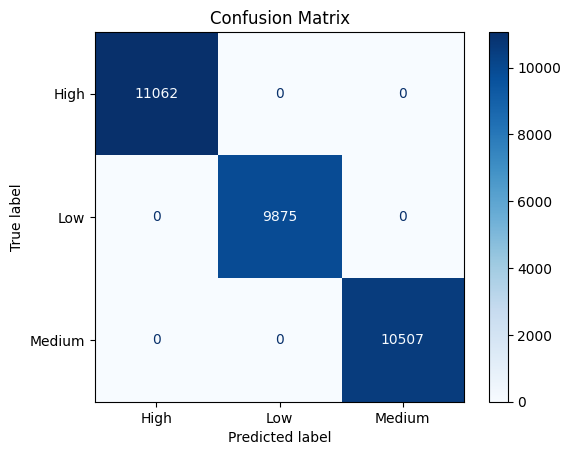

In [29]:
train_labels = np.unique(y_train)
cm = confusion_matrix(y_train, insample_predictions, labels=train_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Out-Sample Evaluation
<p align="Jutisfy"> When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. </p>

In [30]:
# Make predictions on the test data
outsample_predictions = rf_model.predict(X_test)

In [31]:
# calculate accuracy and classification report for in-sample predictions
Y_test = y_test.tolist()
accuracy = accuracy_score(Y_test, outsample_predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(Y_test, outsample_predictions))

Accuracy: 0.521258440305706
              precision    recall  f1-score   support

        High       0.53      0.57      0.55      4742
         Low       0.56      0.50      0.53      4232
      Medium       0.48      0.48      0.48      4503

    accuracy                           0.52     13477
   macro avg       0.52      0.52      0.52     13477
weighted avg       0.52      0.52      0.52     13477



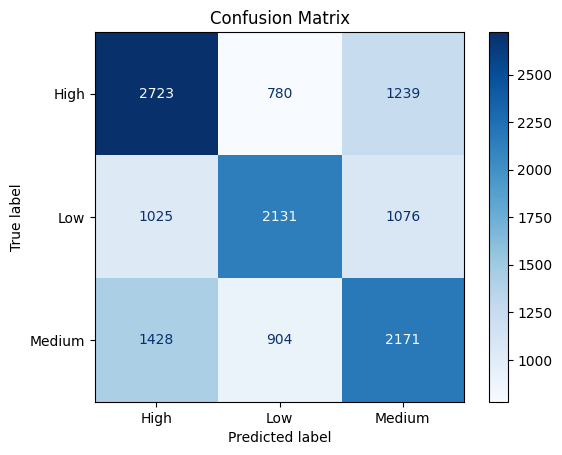

Accuracy: 0.5213


In [32]:
# Compute the confusion matrix to evaluate the classification performance.
test_labels=np.unique(y_test)
cm = confusion_matrix(Y_test, outsample_predictions, labels=test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

# Optional: Print accuracy
print(f"Accuracy: {accuracy_score(Y_test, outsample_predictions):.4f}")

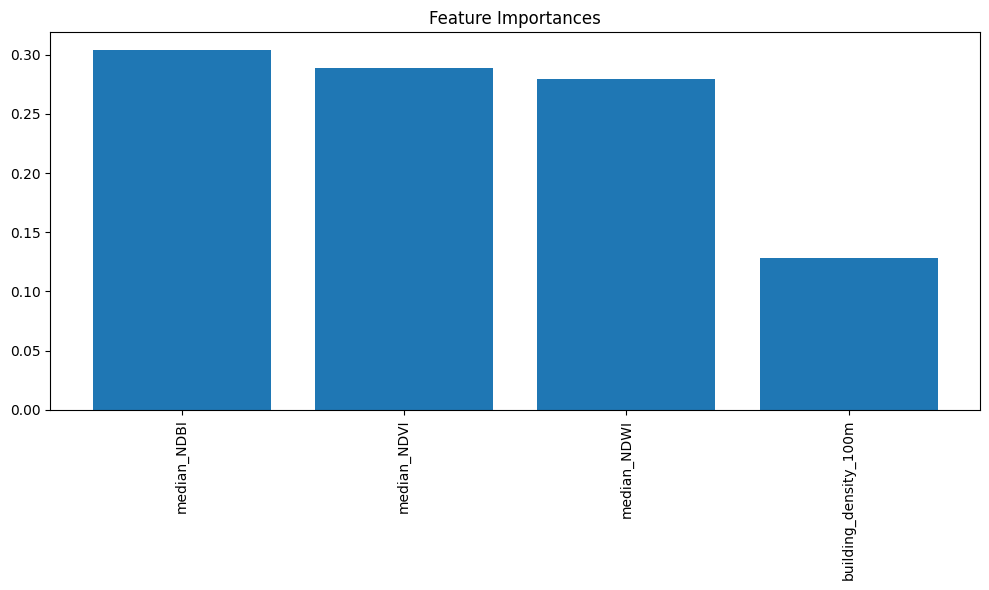

In [33]:
# Extract feature importance scores from the trained random forest model.
importances = rf_model.feature_importances_

# Prepare feature names from the training dataset (excluding target column).
data = train.drop(columns=['UHI_Class'])
feature_names = data.columns

# Sort features by importance in descending order.
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")

# Create a bar plot to visualize the importance of each feature.
plt.bar(range(len(importances)), importances[indices], align='center')

# Set plot title and configure x-axis ticks with feature names rotated for readability.
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

From the above, we see that the model is able to achieve an accuracy of <b>0.5213</b>. This is not a very good score, so your goal is to improve this score.  

## Model Validation on a New Location

Once students are happy with their model, they can validate the model on the dataset of a different location. To validate the model, students will need to use their model to predict the Urban Heat Island (UHI) class for a set of test coordinates provided in the <b>"Validation_Dataset.csv"</b> file and share the predicted results to the instructor/professor.

In [34]:
#Reading the coordinates for the submission
test_file = pd.read_csv('../data/Test.csv')
test_file.head()

,ID,Longitude,Latitude,Target
0,ID_1,-13.272932,8.447807,NaN
1,ID_2,-13.272938,8.447757,NaN
2,ID_3,-13.272997,8.447133,NaN
3,ID_4,-13.273002,8.447015,NaN
4,ID_5,-13.273007,8.446915,NaN


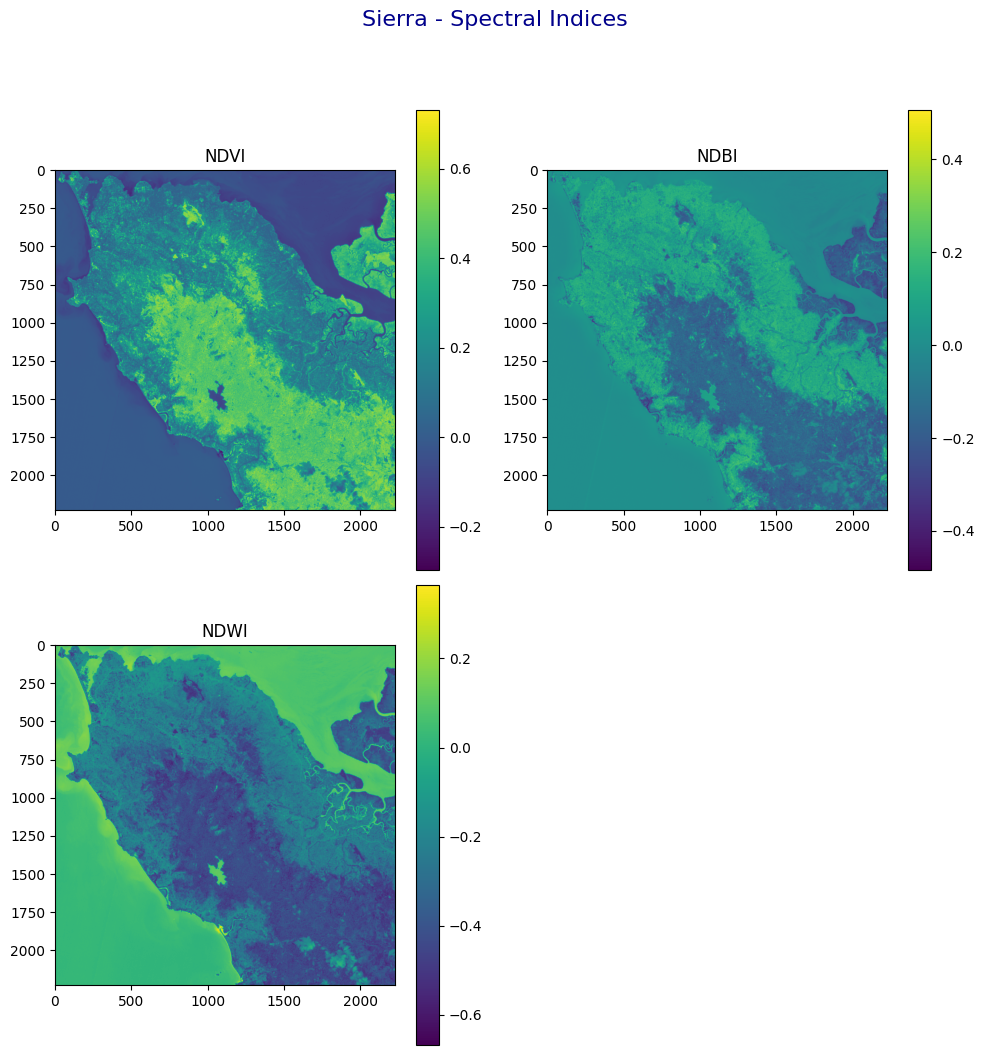

In [36]:
# For Sierra location
plot_spectral_indices("../data/sample_Sierra.tiff", location_name="Sierra")

In [38]:
# Mapping satellite data with training data for the sierra location.
Sierra_heat_data = extract_band_vales(geotiff_path="../data/sample_Sierra.tiff", csv_input_path="../data/Testcsv")
Sierra_heat_data.head()

Mapping values: 100%|██████████| 14105/14105 [01:59<00:00, 118.39it/s]


,ID,Longitude,Latitude,Target,median_NDVI,median_NDBI,median_NDWI
0,ID_1,-13.272932,8.447807,NaN,0.02374893977947413,0.15976331360946747,-0.11192998618148318
1,ID_2,-13.272938,8.447757,NaN,0.02374893977947413,0.15976331360946747,-0.11192998618148318
2,ID_3,-13.272997,8.447133,NaN,0.15561335067186824,0.0887027858485729,-0.2348309402501158
3,ID_4,-13.273002,8.447015,NaN,0.12137823022709475,0.053066622582244996,-0.19159558976492616
4,ID_5,-13.273007,8.446915,NaN,0.10152881223049784,0.08304780551476587,-0.21566082630326627


In [40]:
# Compute building density within 100-meter square buffers around each point 
# in the Sierrs UHI dataset, using building footprints from 'Sierra Leone.shp'.
Sierra_buildings_data = compute_building_density(
    csv_path="../data/Test.csv",
    buildings_shp_path="../data/Sierra Leone Building Footprints/Sierra Leone_clipped.shp")

Sierra_buildings_data.head()


Calculating building density: 100%|██████████| 14105/14105 [07:32<00:00, 31.17it/s]


,ID,Longitude,Latitude,Target,geometry,building_density_100m
0,ID_1,-13.272932,8.447807,NaN,POINT (-1477535.995 943831.442),0.0015
1,ID_2,-13.272938,8.447757,NaN,POINT (-1477536.736 943825.815),0.0014
2,ID_3,-13.272997,8.447133,NaN,POINT (-1477543.231 943755.665),0.0010
3,ID_4,-13.273002,8.447015,NaN,POINT (-1477543.787 943742.348),0.0011
4,ID_5,-13.273007,8.446915,NaN,POINT (-1477544.344 943731.094),0.0011


In [42]:
# Combine UHI data with extracted building density feature for Sierra.
# Selected features include location (Longitude, Latitude), UHI classification,
# median vegetation, built-up, and water indices, along with building density.
sierra_combined = pd.concat([Sierra_heat_data[['Longitude', 'Latitude', 'Target', 'median_NDVI', 'median_NDBI', 'median_NDWI']], 
                             Sierra_buildings_data[['building_density_100m']]], axis=1)

In [43]:
# Create a copy of the Sierra dataset for validation purposes to avoid modifying the original data
test_data=sierra_combined.copy()

In [44]:
# Extracting specific columns (NDVI, NDBI, NDWI, building_density_100m) from the validation dataset
test=test_data.loc[:,['median_NDVI', 'median_NDBI', 'median_NDWI', 'building_density_100m']]
test.head()

,median_NDVI,median_NDBI,median_NDWI,building_density_100m
0,0.02374893977947413,0.15976331360946747,-0.11192998618148318,0.0015
1,0.02374893977947413,0.15976331360946747,-0.11192998618148318,0.0014
2,0.15561335067186824,0.0887027858485729,-0.2348309402501158,0.0010
3,0.12137823022709475,0.053066622582244996,-0.19159558976492616,0.0011
4,0.10152881223049784,0.08304780551476587,-0.21566082630326627,0.0011


In [45]:
test.to_csv('../data/test_data_sierra.csv', index=False)


In [ ]:
# Remember to import test_data_sierra.csv as test
# test = pd.read_csv('../data/test_data_sierra.csv')

In [46]:
# Feature Scaling 
test_transformed = sc.transform(test)
test_transformed

array([[-0.95157287,  1.38629054,  0.42825089,  1.25260124],
       [-0.95157287,  1.38629054,  0.42825089,  1.10043174],
       [ 0.16438878,  0.59589993, -0.75799101,  0.49175372],
       ...,
       [-0.20455806,  0.6759382 , -1.0955219 ,  3.8394828 ],
       [ 0.38288225,  0.58919455, -1.01523219,  4.75249982],
       [-0.310028  ,  0.87445049, -0.72276912,  0.18741472]])

In [47]:
#Making predictions
final_predictions = rf_model.predict(test_transformed)

# Optional: convert to Series if needed
final_prediction_series = pd.Series(final_predictions)

In [48]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'ID':test_file['ID'].values, 'Target':final_prediction_series.values})

In [49]:
#Displaying the sample submission dataframe
display(submission_df)

,ID,Target
0,ID_1,Medium
1,ID_2,Medium
2,ID_3,Low
3,ID_4,Medium
4,ID_5,High
...,...,...
14100,ID_14101,Medium
14101,ID_14102,High
14102,ID_14103,Medium
14103,ID_14104,Medium


In [50]:
#Dumping the predictions into a csv file.
submission_df.to_csv("../submissions/Predicted_Dataset.csv",index=False)

## Conclusion

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. Once you build the final model, please share Predicted_Dataset.csv file with instructor/professor for them to evaluate the performance of the model. Best of luck and happy learning!